In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, r2_score

import mlflow
import mlflow.sklearn
import joblib
import os

In [2]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing()
df = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
df['Price'] = california_housing.target

df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521


## The target variable (HousePrice) typically represents the median house value in units of $100,000

In [3]:
df.rename(columns={
    'MedInc': 'MedianIncome',
    'HouseAge': 'HouseAgeYears',
    'AveRooms': 'AverageRoomsPerHouse',
    'AveBedrms': 'AverageBedroomsPerHouse',
    'Population': 'TotalPopulation',
    'AveOccup': 'AverageOccupantsPerHouse',
    'Latitude': 'Latitude',
    'Longitude': 'Longitude',
    'Price': 'HousePrice'
}, inplace=True)


In [4]:
df.columns, df.dtypes, df.shape

(Index(['MedianIncome', 'HouseAgeYears', 'AverageRoomsPerHouse',
        'AverageBedroomsPerHouse', 'TotalPopulation',
        'AverageOccupantsPerHouse', 'Latitude', 'Longitude', 'HousePrice'],
       dtype='object'),
 MedianIncome                float64
 HouseAgeYears               float64
 AverageRoomsPerHouse        float64
 AverageBedroomsPerHouse     float64
 TotalPopulation             float64
 AverageOccupantsPerHouse    float64
 Latitude                    float64
 Longitude                   float64
 HousePrice                  float64
 dtype: object,
 (20640, 9))

In [5]:
df = df.astype({
    'HouseAgeYears': 'int64',
    'TotalPopulation': 'int64',
})

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

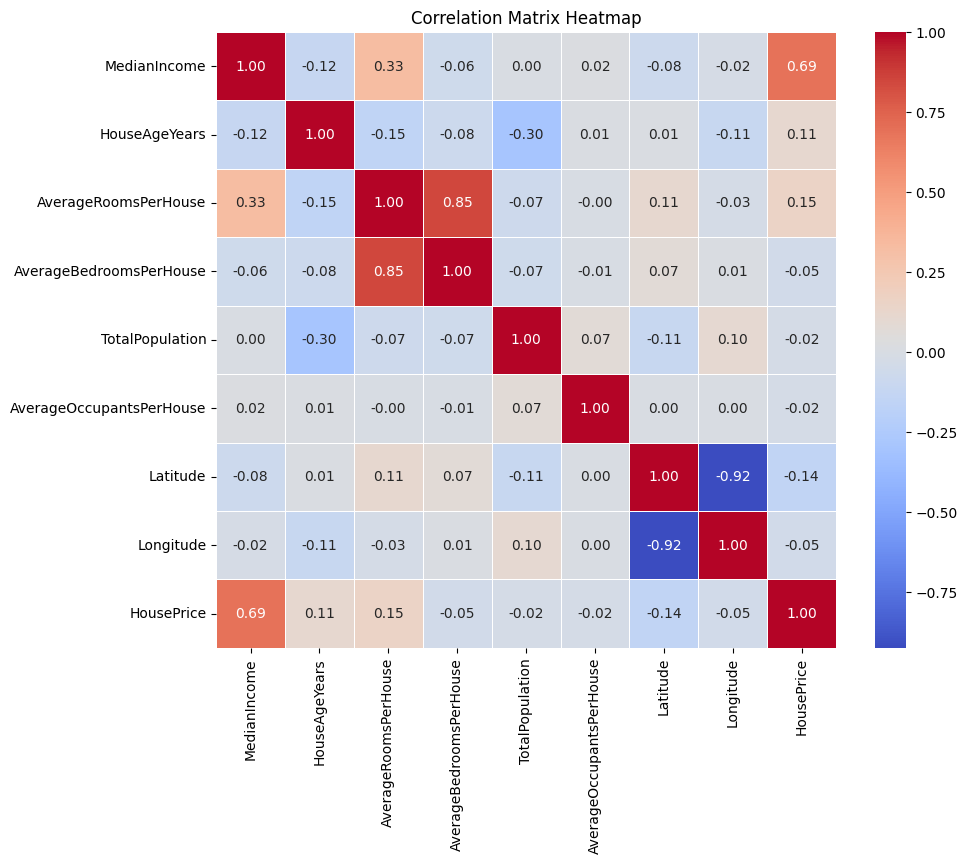

In [6]:
df_corr = df.corr()
plt.figure(figsize=(10, 8))  
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')

In [7]:
X = df.drop(columns="HousePrice", axis=1)
y = df['HousePrice']

In [8]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, X_valid shape: {X_valid.shape}, X_test shape: {X_test.shape}")

X_train shape: (13209, 8), X_valid shape: (3303, 8), X_test shape: (4128, 8)


In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)
    ])

In [11]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [12]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("project-7") 

<Experiment: artifact_location='/Users/emmanuella/Desktop/RGT LEARNING/mlops-zoomcamp/07-Project/mlruns/1', creation_time=1734799963655, experiment_id='1', last_update_time=1734799963655, lifecycle_stage='active', name='project-7', tags={}>

In [13]:
with mlflow.start_run():
    mlflow.set_tag("developer","Emmanuella")
    
    params = {"random_state": 42}
    mlflow.log_params(params)
    
    # model = RandomForestRegressor(**params)
    # model.fit(X_train, y_train)
    
    # y_pred = model.predict(X_test)
    model_pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = model_pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    mlflow.log_metric("Mean Squared Error", mse)
    
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    mlflow.log_metric("Root Mean Squared Error", rmse)
    
    r2 = r2_score(y_test, y_pred)
    print(f"R^2 Score (Accuracy): {r2}")
    mlflow.log_metric("R2 Score", r2)
    
    mlflow.sklearn.log_model(model_pipeline, artifact_path="models")
    print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

    os.makedirs("models", exist_ok=True)
    model_path = "models/lin_reg.bin"
    joblib.dump(model_pipeline, model_path)
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

Mean Squared Error: 0.2666115157005497
Root Mean Squared Error (RMSE): 0.5163443770397328
R^2 Score (Accuracy): 0.7965432776121159


2024/12/24 12:58:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/24 12:58:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run kindly-hawk-686 at: http://127.0.0.1:5000/#/experiments/1/runs/2f1bb57c30014b4394854352072cd418.
2024/12/24 12:58:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


default artifacts URI: '/Users/emmanuella/Desktop/RGT LEARNING/mlops-zoomcamp/07-Project/mlruns/1/2f1bb57c30014b4394854352072cd418/artifacts'


## More Model Experiments

In [14]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [15]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_valid, label=y_valid)

In [16]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_valid, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse) 
    return {'loss': rmse, 'accuracy(r2 score)': r2, 'status': STATUS_OK}


In [17]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [18]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:1.04382                                                                                                                                                 
[1]	validation-rmse:0.93760                                                                                                                                                 
[2]	validation-rmse:0.85636                                                                                                                                                 
[3]	validation-rmse:0.79236                                                                                                                                                 
[4]	validation-rmse:0.73951                                                                                                                                                 
[5]	validation-rmse:0.69974                                                                                                            

2024/12/24 12:58:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run adaptable-horse-370 at: http://127.0.0.1:5000/#/experiments/1/runs/e84354bc05c7481faa5341c925b5ad40.

2024/12/24 12:58:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.67692                                                                                                                                                 
[1]	validation-rmse:0.66670                                                                                                                                                 
[2]	validation-rmse:0.66948                                                                                                                                                 
[3]	validation-rmse:0.66930                                                                                                                                                 
[4]	validation-rmse:0.66954                                                                                                                                                 
[5]	validation-rmse:0.66969                                                                                                            

2024/12/24 12:59:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run aged-dove-334 at: http://127.0.0.1:5000/#/experiments/1/runs/4cdcc7eb622745b2a1c88c0475dbbded.

2024/12/24 12:59:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.08516                                                                                                                                                 
[1]	validation-rmse:1.00835                                                                                                                                                 
[2]	validation-rmse:0.94244                                                                                                                                                 
[3]	validation-rmse:0.88374                                                                                                                                                 
[4]	validation-rmse:0.83306                                                                                                                                                 
[5]	validation-rmse:0.79134                                                                                                            

2024/12/24 12:59:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-shad-171 at: http://127.0.0.1:5000/#/experiments/1/runs/6fc598b20add4c4488da04f271a0feec.

2024/12/24 12:59:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.12059                                                                                                                                                 
[1]	validation-rmse:1.07129                                                                                                                                                 
[2]	validation-rmse:1.02477                                                                                                                                                 
[3]	validation-rmse:0.98135                                                                                                                                                 
[4]	validation-rmse:0.94147                                                                                                                                                 
[5]	validation-rmse:0.90509                                                                                                            

2024/12/24 12:59:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run gifted-ray-827 at: http://127.0.0.1:5000/#/experiments/1/runs/63478d7a81584d7fa2000a5885f39d5e.

2024/12/24 12:59:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.93080                                                                                                                                                 
[1]	validation-rmse:0.77994                                                                                                                                                 
[2]	validation-rmse:0.69160                                                                                                                                                 
[3]	validation-rmse:0.64385                                                                                                                                                 
[4]	validation-rmse:0.61425                                                                                                                                                 
[5]	validation-rmse:0.60014                                                                                                            

2024/12/24 12:59:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-quail-965 at: http://127.0.0.1:5000/#/experiments/1/runs/2ed901883c814e2585e3ba1942fb9c9e.

2024/12/24 12:59:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.70828                                                                                                                                                 
[1]	validation-rmse:0.60058                                                                                                                                                 
[2]	validation-rmse:0.56789                                                                                                                                                 
[3]	validation-rmse:0.56371                                                                                                                                                 
[4]	validation-rmse:0.55656                                                                                                                                                 
[5]	validation-rmse:0.55854                                                                                                            

2024/12/24 12:59:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run skillful-foal-33 at: http://127.0.0.1:5000/#/experiments/1/runs/ae66029d2ccb4ae7b56bfba6321bcf20.

2024/12/24 12:59:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.03767                                                                                                                                                 
[1]	validation-rmse:0.93234                                                                                                                                                 
[2]	validation-rmse:0.85071                                                                                                                                                 
[3]	validation-rmse:0.78297                                                                                                                                                 
[4]	validation-rmse:0.73471                                                                                                                                                 
[5]	validation-rmse:0.69472                                                                                                            

2024/12/24 12:59:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run sedate-vole-219 at: http://127.0.0.1:5000/#/experiments/1/runs/11f6cb9e37fb44c2ba53e6999b020d27.

2024/12/24 12:59:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.71653                                                                                                                                                 
[1]	validation-rmse:0.63172                                                                                                                                                 
[2]	validation-rmse:0.61928                                                                                                                                                 
[3]	validation-rmse:0.61881                                                                                                                                                 
[4]	validation-rmse:0.61721                                                                                                                                                 
[5]	validation-rmse:0.61737                                                                                                            

2024/12/24 12:59:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-calf-960 at: http://127.0.0.1:5000/#/experiments/1/runs/f8e11763c3314a6c923cbae910ebbb60.

2024/12/24 12:59:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.03506                                                                                                                                                 
[1]	validation-rmse:0.92693                                                                                                                                                 
[2]	validation-rmse:0.84346                                                                                                                                                 
[3]	validation-rmse:0.78141                                                                                                                                                 
[4]	validation-rmse:0.73400                                                                                                                                                 
[5]	validation-rmse:0.69775                                                                                                            

2024/12/24 12:59:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run useful-bird-288 at: http://127.0.0.1:5000/#/experiments/1/runs/d91552d965a6428cb1338bf1175d357e.

2024/12/24 12:59:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.83190                                                                                                                                                 
[1]	validation-rmse:0.68868                                                                                                                                                 
[2]	validation-rmse:0.63530                                                                                                                                                 
[3]	validation-rmse:0.61381                                                                                                                                                 
[4]	validation-rmse:0.60654                                                                                                                                                 
[5]	validation-rmse:0.60377                                                                                                            

2024/12/24 12:59:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run dapper-shark-626 at: http://127.0.0.1:5000/#/experiments/1/runs/73c55c5743494d7d855f3dd41967a529.

2024/12/24 12:59:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.81694                                                                                                                                                 
[1]	validation-rmse:0.66397                                                                                                                                                 
[2]	validation-rmse:0.60679                                                                                                                                                 
[3]	validation-rmse:0.57866                                                                                                                                                 
[4]	validation-rmse:0.56910                                                                                                                                                 
[5]	validation-rmse:0.56256                                                                                                            

2024/12/24 12:59:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run youthful-cub-820 at: http://127.0.0.1:5000/#/experiments/1/runs/4716d1fb7fc6459f92aaf2baa3694c8d.

2024/12/24 12:59:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.67070                                                                                                                                                 
[1]	validation-rmse:0.59875                                                                                                                                                 
[2]	validation-rmse:0.59413                                                                                                                                                 
[3]	validation-rmse:0.59478                                                                                                                                                 
[4]	validation-rmse:0.59340                                                                                                                                                 
[5]	validation-rmse:0.59478                                                                                                            

2024/12/24 12:59:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-mouse-834 at: http://127.0.0.1:5000/#/experiments/1/runs/e29a0a4f6fab4070960379c9f6d1dffa.

2024/12/24 12:59:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.02429                                                                                                                                                 
[1]	validation-rmse:0.91145                                                                                                                                                 
[2]	validation-rmse:0.82902                                                                                                                                                 
[3]	validation-rmse:0.76948                                                                                                                                                 
[4]	validation-rmse:0.72851                                                                                                                                                 
[5]	validation-rmse:0.70114                                                                                                            

2024/12/24 12:59:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run valuable-slug-301 at: http://127.0.0.1:5000/#/experiments/1/runs/f837e662c72141dca28a639ae12c823a.

2024/12/24 12:59:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.01314                                                                                                                                                 
[1]	validation-rmse:0.89122                                                                                                                                                 
[2]	validation-rmse:0.80154                                                                                                                                                 
[3]	validation-rmse:0.73473                                                                                                                                                 
[4]	validation-rmse:0.68785                                                                                                                                                 
[5]	validation-rmse:0.65249                                                                                                            

2024/12/24 12:59:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-hawk-267 at: http://127.0.0.1:5000/#/experiments/1/runs/51805e4e6efc4446a524021d000cee52.

2024/12/24 12:59:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.00804                                                                                                                                                 
[1]	validation-rmse:0.88356                                                                                                                                                 
[2]	validation-rmse:0.79282                                                                                                                                                 
[3]	validation-rmse:0.72672                                                                                                                                                 
[4]	validation-rmse:0.68153                                                                                                                                                 
[5]	validation-rmse:0.64865                                                                                                            

2024/12/24 12:59:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run enthused-fly-11 at: http://127.0.0.1:5000/#/experiments/1/runs/b8ee425eeac04f74a2040c5571ccf77b.

2024/12/24 12:59:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.13316                                                                                                                                                 
[1]	validation-rmse:1.09509                                                                                                                                                 
[2]	validation-rmse:1.05999                                                                                                                                                 
[3]	validation-rmse:1.02699                                                                                                                                                 
[4]	validation-rmse:0.99614                                                                                                                                                 
[5]	validation-rmse:0.96780                                                                                                            

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[26]	validation-rmse:0.66636                                                                                                                                                
[27]	validation-rmse:0.66632                                                                                                                                                
[28]	validation-rmse:0.66643                                                                                                                                                
[29]	validation-rmse:0.66655                                                                                                                                                
[30]	validation-rmse:0.66689                                                                                                                                                
[31]	validation-rmse:0.66718                                                                                                           

2024/12/24 12:59:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-smelt-934 at: http://127.0.0.1:5000/#/experiments/1/runs/9812ec0e535e4a24bd01666d725366c7.

2024/12/24 12:59:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.99707                                                                                                                                                 
[1]	validation-rmse:0.87094                                                                                                                                                 
[2]	validation-rmse:0.77957                                                                                                                                                 
[3]	validation-rmse:0.71779                                                                                                                                                 
[4]	validation-rmse:0.67440                                                                                                                                                 
[5]	validation-rmse:0.64609                                                                                                            

2024/12/24 12:59:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run selective-pig-198 at: http://127.0.0.1:5000/#/experiments/1/runs/d26cc469d8814f399991ebae18074aa7.

2024/12/24 12:59:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.07833                                                                                                                                                 
[1]	validation-rmse:0.99686                                                                                                                                                 
[2]	validation-rmse:0.92613                                                                                                                                                 
[3]	validation-rmse:0.86546                                                                                                                                                 
[4]	validation-rmse:0.81419                                                                                                                                                 
[5]	validation-rmse:0.77024                                                                                                            

2024/12/24 12:59:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run placid-cod-375 at: http://127.0.0.1:5000/#/experiments/1/runs/deb7ee849607464c9e28a4b986f3082a.

2024/12/24 12:59:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.10620                                                                                                                                                 
[1]	validation-rmse:1.04554                                                                                                                                                 
[2]	validation-rmse:0.98822                                                                                                                                                 
[3]	validation-rmse:0.93860                                                                                                                                                 
[4]	validation-rmse:0.89279                                                                                                                                                 
[5]	validation-rmse:0.85171                                                                                                            

2024/12/24 12:59:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run worried-shark-157 at: http://127.0.0.1:5000/#/experiments/1/runs/d77cac5e8c9d4177acbdcaab9968f2b7.

2024/12/24 12:59:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.12984                                                                                                                                                 
[1]	validation-rmse:1.08794                                                                                                                                                 
[2]	validation-rmse:1.04882                                                                                                                                                 
[3]	validation-rmse:1.01131                                                                                                                                                 
[4]	validation-rmse:0.97614                                                                                                                                                 
[5]	validation-rmse:0.94292                                                                                                            

2024/12/24 12:59:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run enthused-fowl-147 at: http://127.0.0.1:5000/#/experiments/1/runs/874f6fc9f21343da934bc66fbee97a33.

2024/12/24 12:59:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.11644                                                                                                                                                 
[1]	validation-rmse:1.06532                                                                                                                                                 
[2]	validation-rmse:1.01488                                                                                                                                                 
[3]	validation-rmse:0.97030                                                                                                                                                 
[4]	validation-rmse:0.93068                                                                                                                                                 
[5]	validation-rmse:0.89491                                                                                                            

2024/12/24 12:59:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run efficient-carp-491 at: http://127.0.0.1:5000/#/experiments/1/runs/88c183cd479e4028b0ff6127d9d74b61.

2024/12/24 12:59:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.12446                                                                                                                                                 
[1]	validation-rmse:1.07932                                                                                                                                                 
[2]	validation-rmse:1.03747                                                                                                                                                 
[3]	validation-rmse:0.99846                                                                                                                                                 
[4]	validation-rmse:0.96225                                                                                                                                                 
[5]	validation-rmse:0.93065                                                                                                            

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[8]	validation-rmse:0.85917                                                                                                                                                 
[9]	validation-rmse:0.83669                                                                                                                                                 
[10]	validation-rmse:0.81617                                                                                                                                                
[11]	validation-rmse:0.79753                                                                                                                                                
[12]	validation-rmse:0.78079                                                                                                                                                
[13]	validation-rmse:0.76551                                                                                                           

2024/12/24 12:59:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run merciful-foal-639 at: http://127.0.0.1:5000/#/experiments/1/runs/df66900ac3594271952619c196598bb9.

2024/12/24 12:59:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.06384                                                                                                                                                 
[1]	validation-rmse:0.97242                                                                                                                                                 
[2]	validation-rmse:0.89522                                                                                                                                                 
[3]	validation-rmse:0.83069                                                                                                                                                 
[4]	validation-rmse:0.77656                                                                                                                                                 
[5]	validation-rmse:0.72747                                                                                                            

2024/12/24 12:59:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-ox-715 at: http://127.0.0.1:5000/#/experiments/1/runs/8804cf472ab54a7590bb1922d156069e.

2024/12/24 12:59:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.97060                                                                                                                                                 
[1]	validation-rmse:0.84675                                                                                                                                                 
[2]	validation-rmse:0.76253                                                                                                                                                 
[3]	validation-rmse:0.70356                                                                                                                                                 
[4]	validation-rmse:0.66629                                                                                                                                                 
[5]	validation-rmse:0.62689                                                                                                            

2024/12/24 12:59:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run skillful-yak-329 at: http://127.0.0.1:5000/#/experiments/1/runs/127440e6f7b54a45ab7b02aa45a2d8e0.

2024/12/24 12:59:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.11085                                                                                                                                                 
[1]	validation-rmse:1.05325                                                                                                                                                 
[2]	validation-rmse:0.99903                                                                                                                                                 
[3]	validation-rmse:0.95135                                                                                                                                                 
[4]	validation-rmse:0.90801                                                                                                                                                 
[5]	validation-rmse:0.86903                                                                                                            

2024/12/24 12:59:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run amusing-lark-599 at: http://127.0.0.1:5000/#/experiments/1/runs/6113a7aa87034be89418ba430f47d362.

2024/12/24 12:59:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.08847                                                                                                                                                 
[1]	validation-rmse:1.01412                                                                                                                                                 
[2]	validation-rmse:0.94693                                                                                                                                                 
[3]	validation-rmse:0.88724                                                                                                                                                 
[4]	validation-rmse:0.83805                                                                                                                                                 
[5]	validation-rmse:0.79498                                                                                                            

2024/12/24 12:59:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-wolf-686 at: http://127.0.0.1:5000/#/experiments/1/runs/2d7c5397380e4466b92fc44b4dc966e6.

2024/12/24 12:59:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.06417                                                                                                                                                 
[1]	validation-rmse:0.97240                                                                                                                                                 
[2]	validation-rmse:0.89141                                                                                                                                                 
[3]	validation-rmse:0.82256                                                                                                                                                 
[4]	validation-rmse:0.76534                                                                                                                                                 
[5]	validation-rmse:0.71968                                                                                                            

2024/12/24 13:00:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-hawk-947 at: http://127.0.0.1:5000/#/experiments/1/runs/3818f112ca6341b88f283bdaf532042f.

2024/12/24 13:00:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.13777                                                                                                                                                 
[1]	validation-rmse:1.10362                                                                                                                                                 
[2]	validation-rmse:1.07160                                                                                                                                                 
[3]	validation-rmse:1.04182                                                                                                                                                 
[4]	validation-rmse:1.01322                                                                                                                                                 
[5]	validation-rmse:0.98678                                                                                                            

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[78]	validation-rmse:0.52082                                                                                                                                                
[79]	validation-rmse:0.52073                                                                                                                                                
[80]	validation-rmse:0.52071                                                                                                                                                
[81]	validation-rmse:0.52055                                                                                                                                                
[82]	validation-rmse:0.52045                                                                                                                                                
[83]	validation-rmse:0.52031                                                                                                           

2024/12/24 13:00:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run whimsical-colt-773 at: http://127.0.0.1:5000/#/experiments/1/runs/19f919fafde7438b95dc0907e3b13afe.

2024/12/24 13:00:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.00788                                                                                                                                                 
[1]	validation-rmse:0.89952                                                                                                                                                 
[2]	validation-rmse:0.82197                                                                                                                                                 
[3]	validation-rmse:0.76734                                                                                                                                                 
[4]	validation-rmse:0.73078                                                                                                                                                 
[5]	validation-rmse:0.69341                                                                                                            

2024/12/24 13:00:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run masked-dolphin-572 at: http://127.0.0.1:5000/#/experiments/1/runs/ee83857a9bb7436cb2112280d346e5df.

2024/12/24 13:00:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.09373                                                                                                                                                 
[1]	validation-rmse:1.02471                                                                                                                                                 
[2]	validation-rmse:0.96390                                                                                                                                                 
[3]	validation-rmse:0.90837                                                                                                                                                 
[4]	validation-rmse:0.85918                                                                                                                                                 
[5]	validation-rmse:0.81662                                                                                                            

2024/12/24 13:00:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-conch-199 at: http://127.0.0.1:5000/#/experiments/1/runs/8e1c72819777427a815b6c5a947cda25.

2024/12/24 13:00:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.06721                                                                                                                                                 
[1]	validation-rmse:0.97708                                                                                                                                                 
[2]	validation-rmse:0.90095                                                                                                                                                 
[3]	validation-rmse:0.83726                                                                                                                                                 
[4]	validation-rmse:0.78377                                                                                                                                                 
[5]	validation-rmse:0.73616                                                                                                            

2024/12/24 13:00:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-cod-788 at: http://127.0.0.1:5000/#/experiments/1/runs/54c4bd4328f74c779df6f50cfda4664d.

2024/12/24 13:00:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.12882                                                                                                                                                 
[1]	validation-rmse:1.08608                                                                                                                                                 
[2]	validation-rmse:1.04485                                                                                                                                                 
[3]	validation-rmse:1.00777                                                                                                                                                 
[4]	validation-rmse:0.97208                                                                                                                                                 
[5]	validation-rmse:0.93963                                                                                                            

2024/12/24 13:00:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run secretive-owl-568 at: http://127.0.0.1:5000/#/experiments/1/runs/a0d8f0bf92a94ddbbc531e8bee7ea3d3.

2024/12/24 13:00:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.12323                                                                                                                                                 
[1]	validation-rmse:1.07598                                                                                                                                                 
[2]	validation-rmse:1.03024                                                                                                                                                 
[3]	validation-rmse:0.98795                                                                                                                                                 
[4]	validation-rmse:0.94987                                                                                                                                                 
[5]	validation-rmse:0.91346                                                                                                            

2024/12/24 13:00:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-stag-669 at: http://127.0.0.1:5000/#/experiments/1/runs/51936888c6b149c6ad56426cc03dc09f.

2024/12/24 13:00:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.84724                                                                                                                                                 
[1]	validation-rmse:0.68836                                                                                                                                                 
[2]	validation-rmse:0.61874                                                                                                                                                 
[3]	validation-rmse:0.59313                                                                                                                                                 
[4]	validation-rmse:0.57843                                                                                                                                                 
[5]	validation-rmse:0.57282                                                                                                            

2024/12/24 13:00:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run burly-wren-124 at: http://127.0.0.1:5000/#/experiments/1/runs/a6dcf98d71414214933712df0c616075.

2024/12/24 13:00:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.07790                                                                                                                                                 
[1]	validation-rmse:0.99558                                                                                                                                                 
[2]	validation-rmse:0.92474                                                                                                                                                 
[3]	validation-rmse:0.86370                                                                                                                                                 
[4]	validation-rmse:0.81208                                                                                                                                                 
[5]	validation-rmse:0.76702                                                                                                            

2024/12/24 13:00:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-owl-868 at: http://127.0.0.1:5000/#/experiments/1/runs/c72c19871e51430cb414cceffecea46e.

2024/12/24 13:00:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.11955                                                                                                                                                 
[1]	validation-rmse:1.06906                                                                                                                                                 
[2]	validation-rmse:1.02216                                                                                                                                                 
[3]	validation-rmse:0.97944                                                                                                                                                 
[4]	validation-rmse:0.93845                                                                                                                                                 
[5]	validation-rmse:0.90183                                                                                                            

2024/12/24 13:00:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run bald-hound-605 at: http://127.0.0.1:5000/#/experiments/1/runs/076260ce8aab4b0cb20b6e23db8bf2cd.

2024/12/24 13:00:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.05292                                                                                                                                                 
[1]	validation-rmse:0.95324                                                                                                                                                 
[2]	validation-rmse:0.86754                                                                                                                                                 
[3]	validation-rmse:0.79768                                                                                                                                                 
[4]	validation-rmse:0.73984                                                                                                                                                 
[5]	validation-rmse:0.69515                                                                                                            

2024/12/24 13:00:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run treasured-seal-562 at: http://127.0.0.1:5000/#/experiments/1/runs/a8a41c5423ff489ea86388a6c5199026.

2024/12/24 13:00:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.97204                                                                                                                                                 
[1]	validation-rmse:0.83260                                                                                                                                                 
[2]	validation-rmse:0.73304                                                                                                                                                 
[3]	validation-rmse:0.66716                                                                                                                                                 
[4]	validation-rmse:0.62613                                                                                                                                                 
[5]	validation-rmse:0.59552                                                                                                            

2024/12/24 13:00:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-moose-963 at: http://127.0.0.1:5000/#/experiments/1/runs/8fde1b992a6545beb99e912c7051caa7.

2024/12/24 13:00:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.75485                                                                                                                                                 
[1]	validation-rmse:0.62822                                                                                                                                                 
[2]	validation-rmse:0.59637                                                                                                                                                 
[3]	validation-rmse:0.58825                                                                                                                                                 
[4]	validation-rmse:0.58711                                                                                                                                                 
[5]	validation-rmse:0.58724                                                                                                            

2024/12/24 13:00:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-fish-933 at: http://127.0.0.1:5000/#/experiments/1/runs/4f92a64b5f1347299866ad9ec93485e6.

2024/12/24 13:00:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.87243                                                                                                                                                 
[1]	validation-rmse:0.70360                                                                                                                                                 
[2]	validation-rmse:0.61700                                                                                                                                                 
[3]	validation-rmse:0.57381                                                                                                                                                 
[4]	validation-rmse:0.55585                                                                                                                                                 
[5]	validation-rmse:0.54765                                                                                                            

2024/12/24 13:00:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-yak-560 at: http://127.0.0.1:5000/#/experiments/1/runs/1607e0d9031c44b889b903f2560b3915.

2024/12/24 13:00:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.64448                                                                                                                                                 
[1]	validation-rmse:0.63216                                                                                                                                                 
[2]	validation-rmse:0.63837                                                                                                                                                 
[3]	validation-rmse:0.64026                                                                                                                                                 
[4]	validation-rmse:0.64124                                                                                                                                                 
[5]	validation-rmse:0.63976                                                                                                            

2024/12/24 13:00:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run marvelous-tern-431 at: http://127.0.0.1:5000/#/experiments/1/runs/3b526f3cd34f4e88a913d3ce5cd1931a.

2024/12/24 13:00:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.09394                                                                                                                                                 
[1]	validation-rmse:1.02405                                                                                                                                                 
[2]	validation-rmse:0.96264                                                                                                                                                 
[3]	validation-rmse:0.90779                                                                                                                                                 
[4]	validation-rmse:0.85956                                                                                                                                                 
[5]	validation-rmse:0.81792                                                                                                            

2024/12/24 13:00:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run learned-flea-677 at: http://127.0.0.1:5000/#/experiments/1/runs/4fe3de67de174a8daaad933f07eb096d.

2024/12/24 13:00:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.04113                                                                                                                                                 
[1]	validation-rmse:0.93324                                                                                                                                                 
[2]	validation-rmse:0.84386                                                                                                                                                 
[3]	validation-rmse:0.77183                                                                                                                                                 
[4]	validation-rmse:0.71675                                                                                                                                                 
[5]	validation-rmse:0.67368                                                                                                            

2024/12/24 13:00:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-bat-204 at: http://127.0.0.1:5000/#/experiments/1/runs/82f6d24618484f6e884163d6f9a10395.

2024/12/24 13:00:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.10785                                                                                                                                                 
[1]	validation-rmse:1.04817                                                                                                                                                 
[2]	validation-rmse:0.99523                                                                                                                                                 
[3]	validation-rmse:0.94737                                                                                                                                                 
[4]	validation-rmse:0.90353                                                                                                                                                 
[5]	validation-rmse:0.86394                                                                                                            

2024/12/24 13:00:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run likeable-smelt-585 at: http://127.0.0.1:5000/#/experiments/1/runs/feae20358d274a619a2409698894c089.

2024/12/24 13:00:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.12097                                                                                                                                                 
[1]	validation-rmse:1.07293                                                                                                                                                 
[2]	validation-rmse:1.02710                                                                                                                                                 
[3]	validation-rmse:0.98537                                                                                                                                                 
[4]	validation-rmse:0.94695                                                                                                                                                 
[5]	validation-rmse:0.91146                                                                                                            

2024/12/24 13:00:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run lyrical-wolf-698 at: http://127.0.0.1:5000/#/experiments/1/runs/d292ea936ac847a1b4e412ea1c95ae75.

2024/12/24 13:00:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:0.99821                                                                                                                                                 
[1]	validation-rmse:0.86821                                                                                                                                                 
[2]	validation-rmse:0.77388                                                                                                                                                 
[3]	validation-rmse:0.70401                                                                                                                                                 
[4]	validation-rmse:0.65683                                                                                                                                                 
[5]	validation-rmse:0.62574                                                                                                            

2024/12/24 13:00:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-jay-355 at: http://127.0.0.1:5000/#/experiments/1/runs/6028245b58744ebaa0f5f3e71e3c5396.

2024/12/24 13:00:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



[0]	validation-rmse:1.08139                                                                                                                                                 
[1]	validation-rmse:1.00114                                                                                                                                                 
[2]	validation-rmse:0.93232                                                                                                                                                 
[3]	validation-rmse:0.87302                                                                                                                                                 
[4]	validation-rmse:0.81850                                                                                                                                                 
[5]	validation-rmse:0.77382                                                                                                            

2024/12/24 13:00:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run redolent-skink-585 at: http://127.0.0.1:5000/#/experiments/1/runs/dba27a4c086b4c69b14de29b19fd5f4c.

2024/12/24 13:00:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:57<00:00,  2.35s/trial, best loss: 0.46864320188944175]


In [19]:
import pickle
with mlflow.start_run():
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_valid, label=y_valid)

    best_params ={
    "learning_rate" : 0.07068105887408552,
    "max_depth" : 5,
    "min_child_weight": 0.5129258540979367,
    "objective" : "reg:linear",
    "reg_alpha" : 0.1959651381094002,
    "reg_lambda": 0.008613854781972727,
    "seed" : 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:1.12346
[1]	validation-rmse:1.07782
[2]	validation-rmse:1.03598
[3]	validation-rmse:0.99796
[4]	validation-rmse:0.96237
[5]	validation-rmse:0.93020
[6]	validation-rmse:0.90138
[7]	validation-rmse:0.87377
[8]	validation-rmse:0.84892
[9]	validation-rmse:0.82655
[10]	validation-rmse:0.80656
[11]	validation-rmse:0.78812
[12]	validation-rmse:0.77097
[13]	validation-rmse:0.75552
[14]	validation-rmse:0.74087
[15]	validation-rmse:0.72847
[16]	validation-rmse:0.71636
[17]	validation-rmse:0.70550
[18]	validation-rmse:0.69388
[19]	validation-rmse:0.68309
[20]	validation-rmse:0.67549
[21]	validation-rmse:0.66694
[22]	validation-rmse:0.65957
[23]	validation-rmse:0.65265
[24]	validation-rmse:0.64688
[25]	validation-rmse:0.64044
[26]	validation-rmse:0.63521
[27]	validation-rmse:0.63047
[28]	validation-rmse:0.62281
[29]	validation-rmse:0.61567
[30]	validation-rmse:0.61180
[31]	validation-rmse:0.60685
[32]	validation-rmse:0.60365
[33]	validation-rmse:0.59813
[34]	validation-rmse:0.5

2024/12/24 13:00:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/24 13:00:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-crane-603 at: http://127.0.0.1:5000/#/experiments/1/runs/a82512716a004af69ff176a4714fe426.
2024/12/24 13:00:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [28]:
import mlflow
logged_model = 'runs:/499917b74c3246789df1f69df8143540/models_mlflow'

loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 499917b74c3246789df1f69df8143540

In [29]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
y_pred = xgboost_model.predict(valid)

In [30]:
r2 = r2_score(y_valid, y_pred)

In [31]:
r2

0.8395020720452369